# Access Rogue from notebook

## -------------------- BASIC START ------------------

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = True,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 14:57:20
GitHash      = 0x7396087201c6d0e2c27a74a429eb8ea72bd323fe
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 19 Jul 2023 01:22:51 PM PDT
Builder      = dnajjar
###################################################


# Open Interface: 


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='rdsrv314:9099'

In [3]:
"""
REGISTER(s): SHORT-HAND
"""
# SETUP SHORT HAND FOR ROOT CALLS
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
WRITER = root.dataWriter._writer
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [9]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/noteb

## Template test

In [5]:
#get locked lanes
for asicIndex in range(4) : 
    root.App.SspMonGrp[asicIndex].enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [6]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x0
ASIC1: 0x100101
ASIC2: 0xc90020
ASIC3: 0x0


In [7]:
#check current frames in receivers
for asicIndex in range(4):
    print("Checkpoint: DataReceiver {} has {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

Checkpoint: DataReceiver 0 has 0 frames
Checkpoint: DataReceiver 1 has 0 frames
Checkpoint: DataReceiver 2 has 0 frames
Checkpoint: DataReceiver 3 has 0 frames


In [98]:
#trigger. Running some triggers to get rid of first descramble errors. Run only once. After this running a single 
# trigger should suffice
print("Before Trigger: {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))
for asicIndex in range(10):
    root.Trigger()
    time.sleep(0.1)
print("After Trigger:  {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))

Before Trigger: 4314
After Trigger:  4324


In [99]:
# Obtain descrambled single frame data from ASICs from DataReceiver
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

print(frame)

[array([0], dtype=uint8), array([0], dtype=uint8), array([0], dtype=uint8), array([[16895, 16800, 16244, ..., 19878, 18851, 18619],
       [17229, 17545, 16399, ..., 20047, 19274, 18839],
       [17072, 17255, 16030, ..., 20019, 19189, 19219],
       ...,
       [17074, 18191, 17898, ..., 21688, 18794, 19945],
       [17366, 18174, 18027, ..., 21599, 19177, 19754],
       [17040, 18283, 18429, ..., 21474, 18833, 19817]])]


In [100]:
#frame dimensions
for asicIndex in range(4):
    print(np.shape(frame[asicIndex]))

(1,)
(1,)
(1,)
(192, 384)


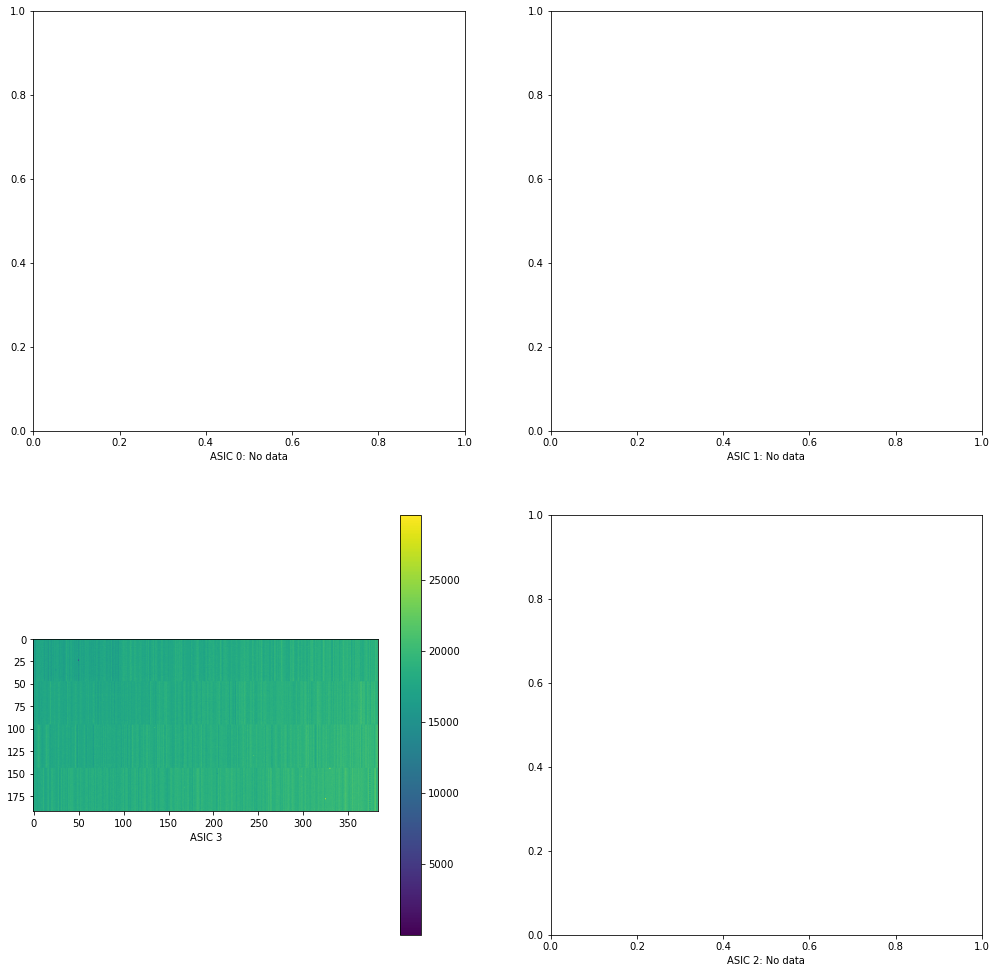

In [105]:
#plot image
plt.subplots(2,2,figsize=(17,17))
for asicIndex in range(4):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
    else :
        plt.subplot(2,2,asicIndex+1)
    
    if np.shape(frame[asicIndex])[0] != 1 :
        plt.imshow(frame[asicIndex])
        plt.xlabel("ASIC {}".format(asicIndex))
        plt.colorbar()
    else :
        plt.xlabel("ASIC {}: No data".format(asicIndex))

In [14]:
#Manipulate ASIC register
for asicIndex in range(4) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    

In [12]:
!ls *.dat

data_20230726_133618.dat  test.dat
Set Auto Trigger command executed
Start Auto Trigger command executed
Stop Triggers command executed


In [14]:
# Setting up the Data Acquisition
#
def acquire(filename, frames) :

    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    
    print(filename)
    
    # Setup and open the file writer
    writer = WRITER
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = TRIG.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    TRIG.AutoTrigPeriod.set(156250000)
    TRIG.AutoRunEn.set(True)
    TRIG.RunTriggerEnable.set(True)

    # Wait for the file write to write the 10 waveforms
    while(writer.getFrameCount() < frames):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    TRIG.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = TRIG.AcqCount.get() - AcqCount
    print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

In [15]:
filename = "test.dat"
acquire(filename, 10)

test.dat
Aquisition Counter 2142
Number of frames received: 0
Number of frames received: 0
Number of frames received: 0
Number of frames received: 0
Number of frames received: 0
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
Number of frames received: 1
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "/u/gu/

TypeError: object of type 'NoneType' has no len()

In [13]:
ls *.dat

data_20230726_133618.dat  data_20230726_135913.dat  test.dat


In [14]:
"""
CONVERT: DAT TO HDF5
"""
# --- FAST MULTI-CORE METHOD --- #
# Note: For 130k frames at x20 cores, takes ~1.5 hours
DAT_to_HDF5 = '{}/imgProc/read_image_from_file_ePixMHrv2.py'.format(rootTopLevel)
print('Waiting... runing in process... when * changes to a number then done')
%run {DAT_to_HDF5} {"data_20230726_135913.dat"} {"--cores=10"}

Waiting... runing in process... when * changes to a number then done
Starting to get data set 0
Message

file: <_io.BufferedReader name='data_20230726_135913.dat'>

size [] previous size [  147508 33554434]
numberOfFrames read:  28
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  28
Starting descrambling images
Saving Hdf5
(192, 384)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [95]:
DEBUG3.enableAcq()
numberOfTriggers = 1000
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [97]:
# Although the triggers above may have finished, this may still be processing. Run several times.
print(DEBUG3.getData().shape)

(192, 384, 501)


In [ ]:
plt.imshow(DEBUG3.getData()[:,:,90])

In [ ]:
DEBUG3.cleanData()
print(DEBUG3.getData().shape)
DEBUG3.disableAcq()